# Spatial Analysis of Airbnb and Housing Market Dynamics in the UK

## Data Sources
The Airbnb data is scraped from public sources or platforms like Inside Airbnb. The major columns in the Airbnb dataset is as follows:

### Data Columns

| Column Name                  | Interpretation                  |
|------------------------------|---------------------------------|
| listing_id                   | Unique identifier               |
| latitude                     | Latitude coordinate             |
| longitude                    | Longitude coordinate            |
| roomtype                     | Room type                       |
| accomodates                  | No of People accomation         |
| beds                         | No of beds                      |
| bathrooms                    | No of bathrooms                 |
| price                        | Price of the room               |
| neighbourhood_cleansed       | Borough                         |
| host_id                      | Host ID                         |
| number_of_reviews            | Total Reviews of Airbnb         |


# Loading Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from scipy import stats

### Data Loading

In [2]:
airbnb_listings = pd.read_csv('data/Airbnb listings.csv')

In [3]:
airbnb_columns_needed = ['id','latitude','longitude','price','room_type',
                         'number_of_reviews','host_id','neighbourhood_cleansed']
airbnb_filtered = airbnb_listings[airbnb_columns_needed]

### Data Checks and Cleaning

In [4]:
airbnb_filtered.isna().sum()

id                            0
latitude                      0
longitude                     0
price                     32967
room_type                     0
number_of_reviews             0
host_id                       0
neighbourhood_cleansed        0
dtype: int64

In [5]:
airbnb_filtered=airbnb_filtered.dropna()

In [6]:
airbnb_filtered.isna().sum()

id                        0
latitude                  0
longitude                 0
price                     0
room_type                 0
number_of_reviews         0
host_id                   0
neighbourhood_cleansed    0
dtype: int64

### Descriptive Statistics

In [7]:
airbnb_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
id,57885.0,6.049403e+17,4.458387e+17,13913.000000,4.430115e+07,7.998744e+17,9.891950e+17,1.115348e+18
latitude,57885.0,5.150908e+01,4.959439e-02,51.295937,5.148465e+01,5.151297e+01,5.153738e+01,5.168178e+01
longitude,57885.0,-1.301117e-01,1.052160e-01,-0.497800,-1.924730e-01,-1.331629e-01,-6.914000e-02,2.957307e-01
number_of_reviews,57885.0,2.212867e+01,4.925562e+01,0.000000,1.000000e+00,5.000000e+00,2.100000e+01,1.457000e+03
host_id,57885.0,2.081430e+08,1.950024e+08,2594.000000,2.910536e+07,1.345193e+08,4.078623e+08,5.677004e+08


##  Exploratory Data Analysis (EDA)

#### Helper function for creating histograms for all columns with numeric values in search for some obvious anomalies.

In [8]:
def numeric_cols_hist(data, width, height):
        cols = data.select_dtypes(include=('number')).columns.to_list()
        data[cols].hist(bins=30, figsize=(width, height))
        plt.show()
        print('Here, density of values in each numeric column is shown.')

### Converting price column from string to float

In [9]:
airbnb_filtered.loc[:,'price'] = airbnb_filtered['price'].replace('[\$,]', '', regex=True).astype(float)

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_2957/168889394.py:1: SyntaxWarning: invalid escape sequence '\$'
  airbnb_filtered.loc[:,'price'] = airbnb_filtered['price'].replace('[\$,]', '', regex=True).astype(float)


#### Mapping of "room_type" column

In [10]:
airbnb_filtered['room_type_category'] = np.nan
i = 0
for item in airbnb_filtered.groupby('room_type').price.median().sort_values(ascending=False).index:
    airbnb_filtered.loc[airbnb_filtered['room_type'] == item, 'room_type_category'] = i
    print(f'- {i} - {item}')
    i += 1

airbnb_filtered['room_type_category'] = airbnb_filtered['room_type_category'].astype('int')
airbnb_filtered[['room_type', 'room_type_category']].head()

- 0 - Entire home/apt
- 1 - Hotel room
- 2 - Private room
- 3 - Shared room


,room_type,room_type_category
0,Entire home/apt,0
1,Private room,2
2,Entire home/apt,0
3,Private room,2
4,Entire home/apt,0


#### Mapping of "neighborhood_cleansed" column
This column shows the 32 London boroughs

In [11]:
neighbourhood_by_price = (airbnb_filtered
 .groupby('neighbourhood_cleansed')
 .agg(median_price=('price', 'median'))
 .sort_values(by='median_price', ascending=False)
).index.to_list()

airbnb_filtered['neighbourhood_category'] = np.nan
i = 0
for item in neighbourhood_by_price:
    print(f'- {i} - {item}')
    airbnb_filtered.loc[airbnb_filtered['neighbourhood_cleansed'] == item, 'neighbourhood_category'] = i
    i += 1
airbnb_filtered.loc[:,'neighbourhood_category'] = airbnb_filtered['neighbourhood_category'].astype('int')
airbnb_filtered[['neighbourhood_cleansed', 'neighbourhood_category']].head()

- 0 - Westminster
- 1 - Kensington and Chelsea
- 2 - City of London
- 3 - Camden
- 4 - Hammersmith and Fulham
- 5 - Richmond upon Thames
- 6 - Wandsworth
- 7 - Islington
- 8 - Hackney
- 9 - Southwark
- 10 - Tower Hamlets
- 11 - Lambeth
- 12 - Newham
- 13 - Barnet
- 14 - Merton
- 15 - Havering
- 16 - Greenwich
- 17 - Brent
- 18 - Hounslow
- 19 - Haringey
- 20 - Kingston upon Thames
- 21 - Ealing
- 22 - Lewisham
- 23 - Bromley
- 24 - Waltham Forest
- 25 - Barking and Dagenham
- 26 - Enfield
- 27 - Harrow
- 28 - Redbridge
- 29 - Bexley
- 30 - Croydon
- 31 - Hillingdon
- 32 - Sutton


,neighbourhood_cleansed,neighbourhood_category
0,Hackney,8.0
1,Islington,7.0
2,Kensington and Chelsea,1.0
3,Lambeth,11.0
4,Kensington and Chelsea,1.0


#### Count of Unique Airbnb listing for every neighborhood 
This will show us how many airbnb exists in each borough

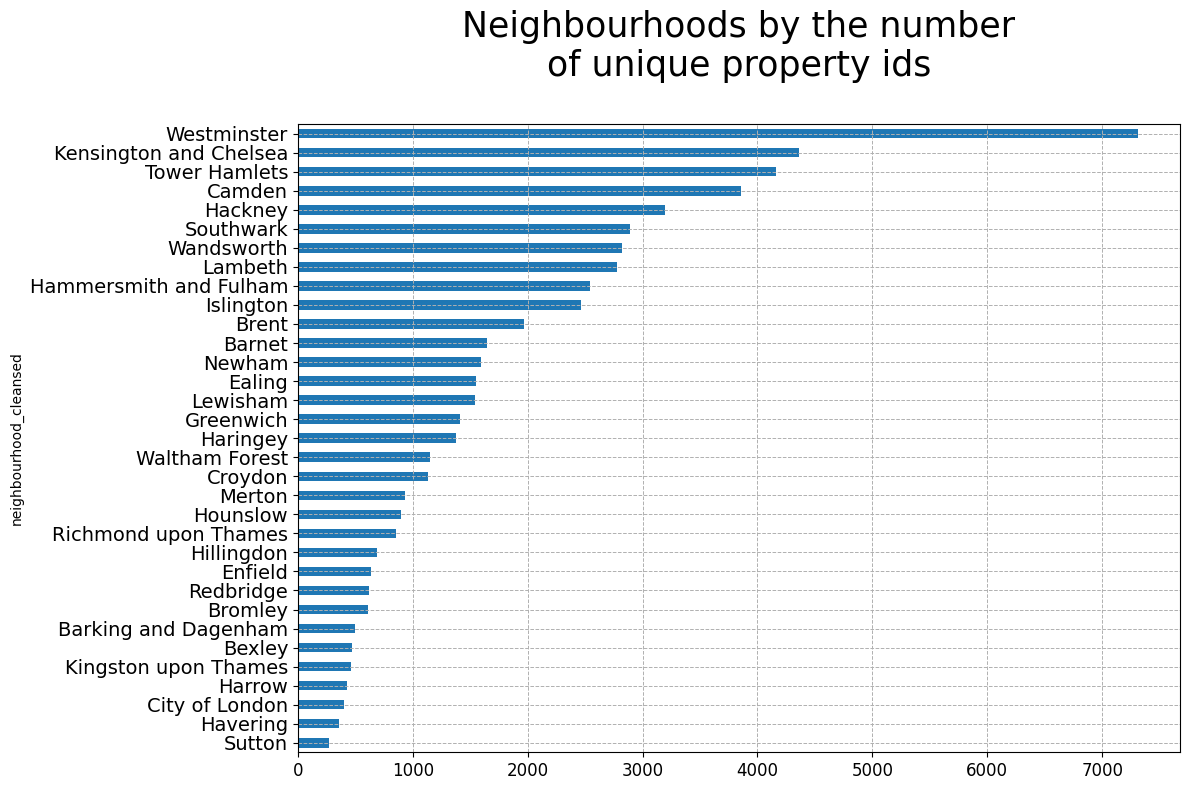

In [12]:
grouped_by_neighbourhood = (airbnb_filtered
                             .groupby('neighbourhood_cleansed')
                             .agg(number_of_ids=('id', 'nunique'))
                             .sort_values(by='number_of_ids', ascending=False))

# Create the plot with a larger figure size
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize as needed

grouped_by_neighbourhood.sort_values(by='number_of_ids').plot(kind='barh', legend=False, ax=ax)

plt.title('Neighbourhoods by the number\nof unique property ids\n', fontsize=25)

# Adjust x-axis tick parameters
plt.xticks(fontsize=12)  # Change 12 to your desired font size
ax.tick_params(axis='x', which='both', labelsize=12)  # Change 12 to your desired font size

# Adjust y-axis label font size and rotation
plt.yticks(fontsize=14)  # Change 14 to your desired font size
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Adjust the layout to make sure labels fit
plt.tight_layout()

plt.show()


#### Top 10 most active neighbourhoods

In [13]:
print('Based on the number of unique object ids, the most active neighbourhoods are as follows (top 10):')
i = 1
for elem in grouped_by_neighbourhood.head(10).index:
    print(f'{i}. {elem}')
    i += 1

Based on the number of unique object ids, the most active neighbourhoods are as follows (top 10):
1. Westminster
2. Kensington and Chelsea
3. Tower Hamlets
4. Camden
5. Hackney
6. Southwark
7. Wandsworth
8. Lambeth
9. Hammersmith and Fulham
10. Islington


#### Top 10 Neighborhoods with highest number of Airbnb's

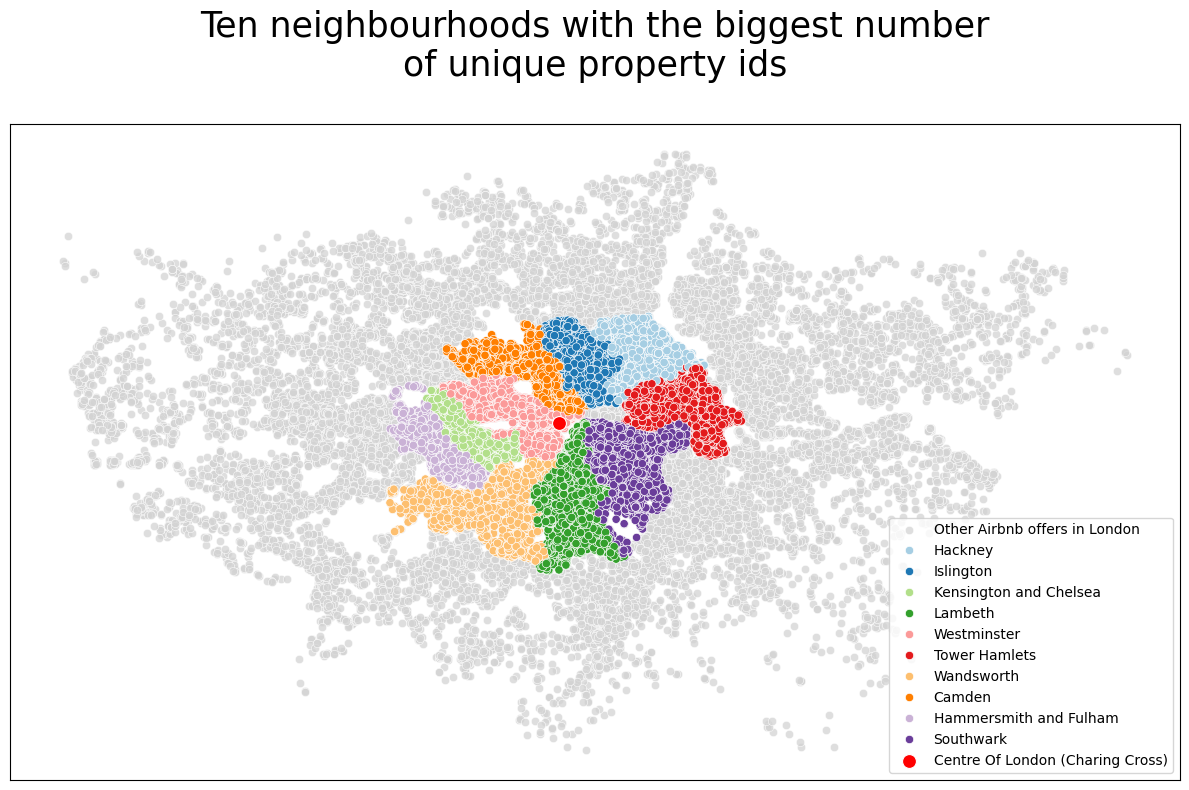

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize as needed

# Plot all Airbnb offers in a specific color
sns.scatterplot(data=airbnb_filtered, y='latitude', x='longitude',
                alpha=.75, color='lightgrey', label='Other Airbnb offers in London', ax=ax)

# Plot the top 10 neighbourhoods with a custom color palette
palette = sns.color_palette("Paired", n_colors=len(grouped_by_neighbourhood.head(10)))  # Change to your desired palette
sns.scatterplot(data=airbnb_filtered.query("neighbourhood_cleansed in @grouped_by_neighbourhood.head(10).index"),
                y='latitude', x='longitude', hue='neighbourhood_cleansed', palette=palette, ax=ax)

# Plot the notional center of London in a different color
sns.scatterplot(x=[-0.1277], y=[51.5075], s=100, color='Red', label='Centre Of London (Charing Cross)', ax=ax)

# Set the title with a larger font size
plt.title('Ten neighbourhoods with the biggest number\nof unique property ids\n', fontsize=25)

# Adjust the legend to make it smaller and ensure it fits within the plot
plt.legend(fontsize=10)  # Change 10 to your desired font size

# Remove x and y axis labels and ticks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Adjust layout to make sure everything fits well
plt.tight_layout()

plt.show()

#### Airbnb properties and their prices per neighbourhood

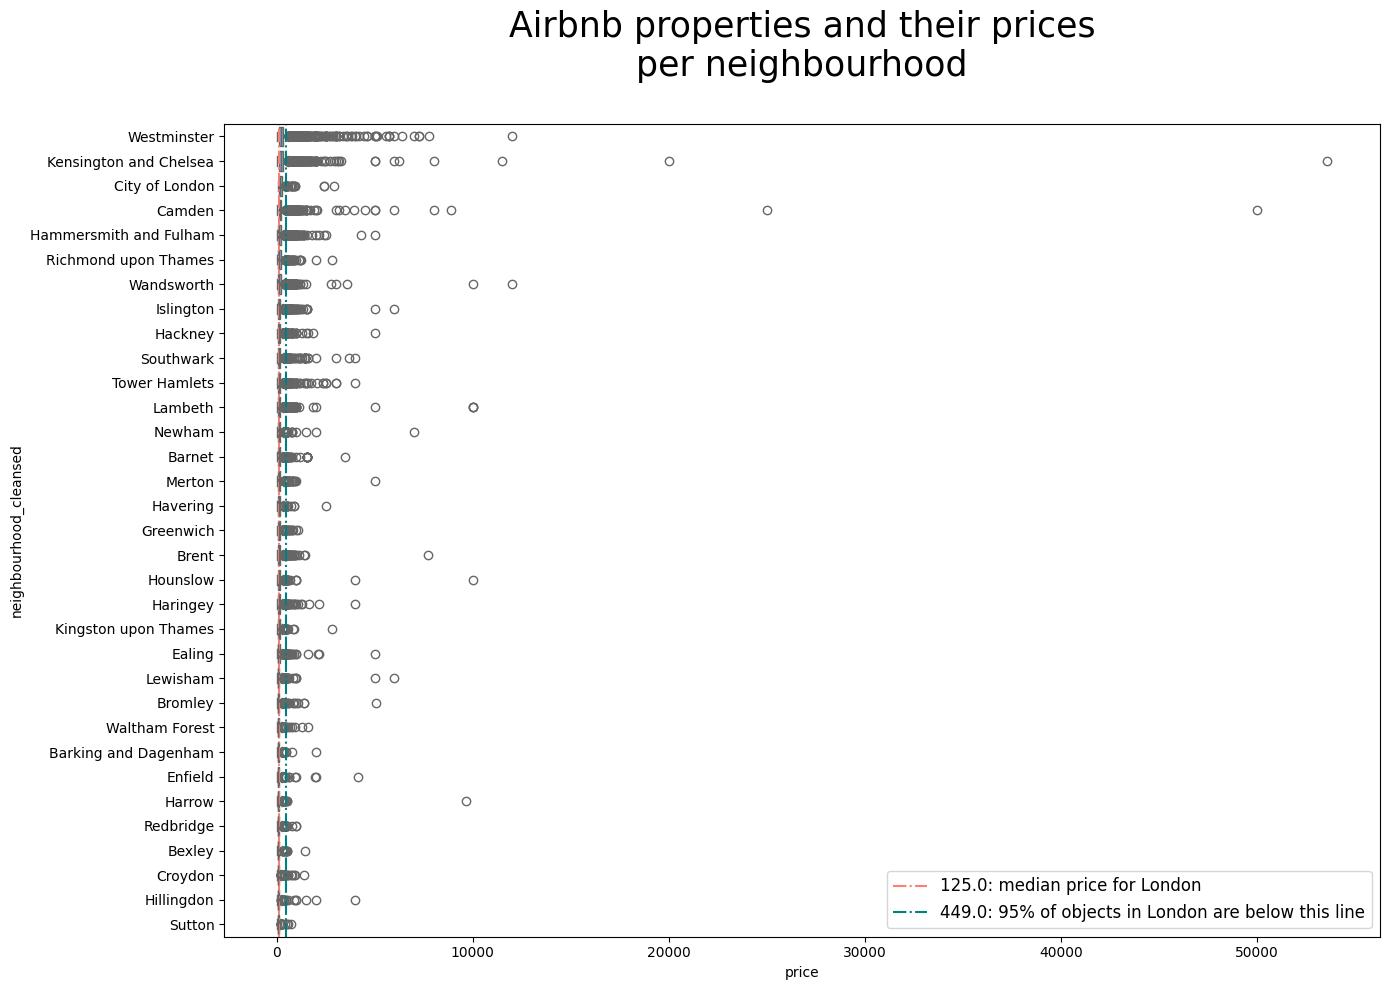

* Areas are ordered by the median price per offer.


In [165]:
# Create the plot with a larger figure size
fig, ax = plt.subplots(figsize=(14, 10))  # Adjust figsize as needed

# Create the boxplot
sns.boxplot(y='neighbourhood_cleansed', x='price', data=airbnb_filtered,
            orient='h', order=neighbourhood_by_price, color='#7eb0d5', ax=ax)

# Add vertical lines for median and 95th percentile
plt.axvline(x=airbnb_filtered.price.median(), color='#fd7f6f', linestyle='dashdot',
            label=f'{airbnb_filtered.price.median()}: median price for London')
plt.axvline(x=airbnb_filtered.price.quantile(.95), color='teal', linestyle='dashdot',
            label=f'{airbnb_filtered.price.quantile(.95)}: 95% of objects in London are below this line')

# Set the title with a larger font size
plt.title('Airbnb properties and their prices\nper neighbourhood\n', fontsize=25)

# Adjust the legend
plt.legend(fontsize=12)  # Change 12 to your desired font size for the legend

# Show the plot
plt.tight_layout()
plt.show()

print('* Areas are ordered by the median price per offer.')

### Preparing Data for Visualization
The data is scaled so that the visualization can be done properly

In [166]:
# Calculating percentiles within the 'groupby' tables.
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [167]:
(
    (round(
        airbnb_filtered
        .groupby('neighbourhood_cleansed')
        .agg(unique_ids=('id', 'nunique'),
            price_5percent=('price', percentile(5)),
             min_price=('price', 'min'),              
            median_price=('price', 'median'),
             price_95percent=('price', percentile(95)),
             max_price=('price', 'max')
    ).sort_values(by='median_price', ascending=False), 0)
    .style.background_gradient(axis='index')
    )
)

,unique_ids,price_5percent,min_price,median_price,price_95percent,max_price
neighbourhood_cleansed,,,,,,
Westminster,7312,65.000000,25.000000,200.000000,758.000000,12000.000000
Kensington and Chelsea,4362,75.000000,28.000000,200.000000,720.000000,53588.000000
City of London,398,95.000000,49.000000,182.000000,497.000000,2936.000000
Camden,3860,52.000000,15.000000,152.000000,467.000000,50000.000000
Hammersmith and Fulham,2541,49.000000,13.000000,134.000000,420.000000,5000.000000
Richmond upon Thames,853,44.000000,25.000000,131.000000,499.000000,2800.000000
Wandsworth,2825,45.000000,24.000000,130.000000,450.000000,12000.000000
Islington,2460,49.000000,9.000000,125.000000,350.000000,6000.000000
Hackney,3193,44.000000,19.000000,124.000000,315.000000,5000.000000


#### Creating copy of the dataframe for changes

In [169]:
new_airbnb = airbnb_filtered.copy()

In [171]:
for district in neighbourhood_by_price:
    print(f'Working with prices in: {district}.')
    top_line = new_airbnb.query('neighbourhood_cleansed == @district')['price'].quantile(.95)
    bottom_line = new_airbnb.query('neighbourhood_cleansed == @district')['price'].quantile(.05)
    print(f'About 95% of objects are priced at more than {round(bottom_line, 0)} and no more than {round(top_line, 0)} (respectively).')
    new_airbnb.loc[((new_airbnb['neighbourhood_cleansed'] == district) &
              ((new_airbnb['price'] < bottom_line) |
               (new_airbnb['price'] > top_line))),
             'price'] = np.nan
    print('Supercheap and ultra-expensive properties are wiped away.')
    print()
print(25*'_')    
print()
print(f"Currently, there are {round((new_airbnb.price.isna().sum() / len(new_airbnb.price)) * 100, 2)}% of NaNs in 'price' column.")
print(f'By dropping lines with NaNs (the most expensive and cheapest properties), we are erasing {round((new_airbnb.price.isna().sum() / len(new_airbnb.price)) * 100, 2)}% of data.')
data = new_airbnb.dropna(axis=0, subset=['price'])
print('\n-----> NaNs were dropped.')
print(f"Now, there are {round((data.price.isna().sum() / len(data.price)) * 100, 2)}% of NaNs in 'price' column.")


Working with prices in: Westminster.
About 95% of objects are priced at more than 65.0 and no more than 758.0 (respectively).
Supercheap and ultra-expensive properties are wiped away.

Working with prices in: Kensington and Chelsea.
About 95% of objects are priced at more than 75.0 and no more than 720.0 (respectively).
Supercheap and ultra-expensive properties are wiped away.

Working with prices in: City of London.
About 95% of objects are priced at more than 95.0 and no more than 497.0 (respectively).
Supercheap and ultra-expensive properties are wiped away.

Working with prices in: Camden.
About 95% of objects are priced at more than 52.0 and no more than 467.0 (respectively).
Supercheap and ultra-expensive properties are wiped away.

Working with prices in: Hammersmith and Fulham.
About 95% of objects are priced at more than 49.0 and no more than 420.0 (respectively).
Supercheap and ultra-expensive properties are wiped away.

Working with prices in: Richmond upon Thames.
About 95%

In [172]:
(
    (
        data
        .groupby('neighbourhood_cleansed')
        .agg(min_price=('price', 'min'),
            median_price=('price', 'median'),
            mean_price=('price', 'mean'),
            max_price=('price', 'max')
    ).sort_values(by='median_price', ascending=False)
    .style.background_gradient(axis=0)
    )
)

,min_price,median_price,mean_price,max_price
neighbourhood_cleansed,,,,
Westminster,65.000000,200.000000,237.428333,757.000000
Kensington and Chelsea,75.000000,200.000000,237.137659,720.000000
City of London,95.000000,182.000000,199.030726,497.000000
Camden,52.000000,151.000000,172.375323,467.000000
Hammersmith and Fulham,49.000000,133.000000,153.391551,420.000000
Wandsworth,45.000000,130.000000,150.512962,449.000000
Richmond upon Thames,44.000000,130.000000,159.323797,499.000000
Islington,49.000000,125.000000,137.241783,350.000000
Hackney,44.000000,124.000000,133.445833,315.000000


* The above table shows the minimum price, median price, mean price and maximum price of all the Airbnbs in each London borough. The highest value in median price, mean price and maximum price has been observed in Westminster. 

* However, the highest value in minimum price has been observed in City of London. 

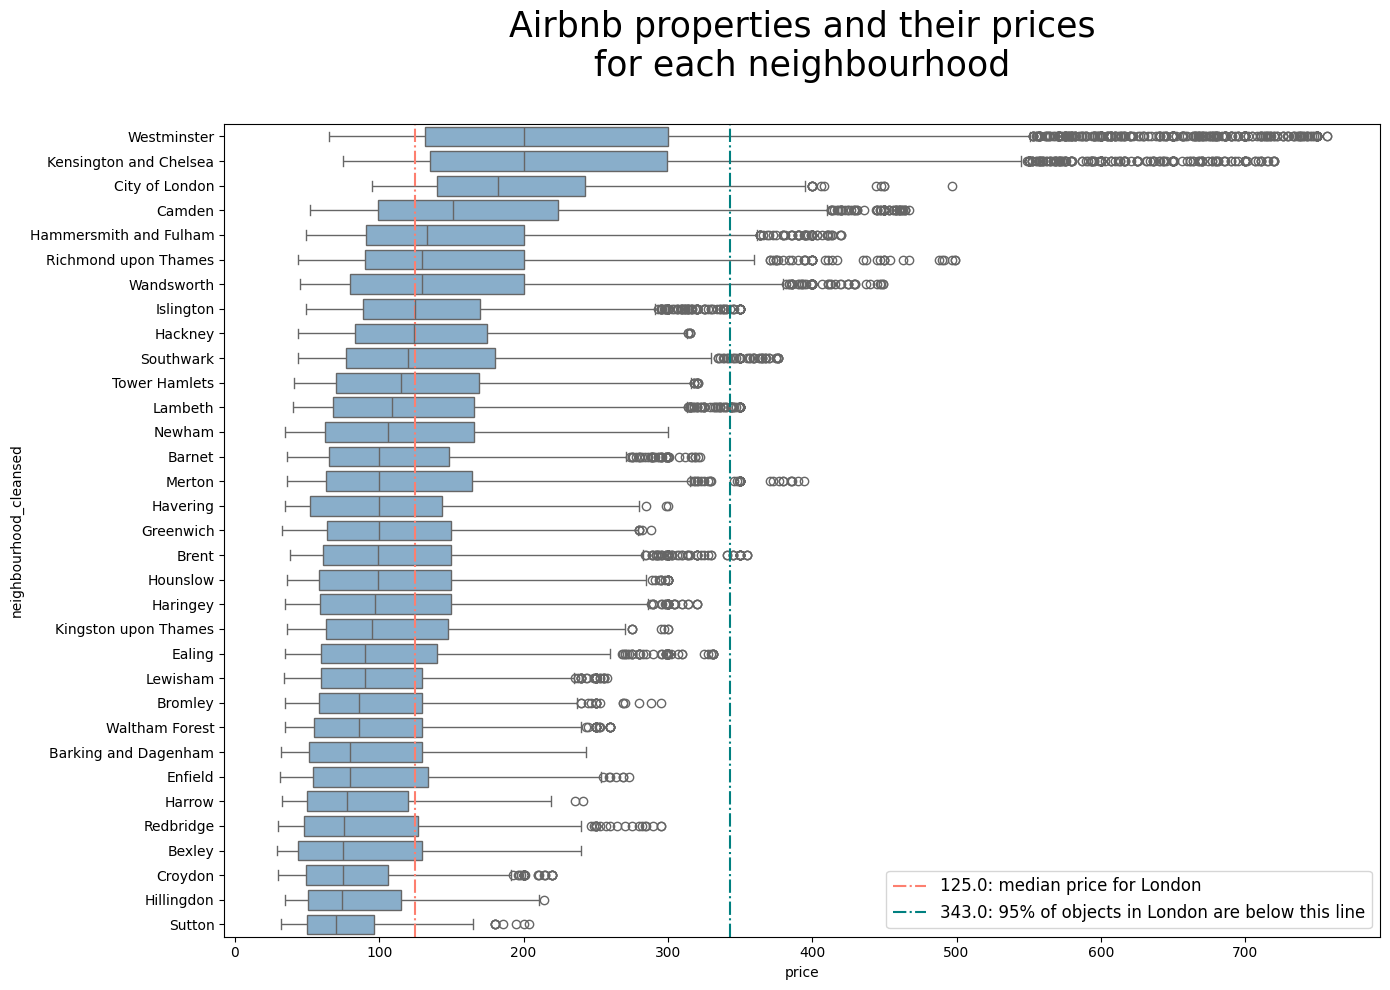

In [174]:
# Create the plot with a larger figure size
fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figsize as needed

# Create the boxplot
sns.boxplot(y='neighbourhood_cleansed', x='price', data=data,
            orient='h', order=neighbourhood_by_price, color='#7eb0d5', ax=ax)

# Add vertical lines for median and 95th percentile
plt.axvline(x=data.price.median(), color='#fd7f6f', linestyle='dashdot',
            label=f'{data.price.median()}: median price for London')
plt.axvline(x=data.price.quantile(.95), color='teal', linestyle='dashdot',
            label=f'{data.price.quantile(.95)}: 95% of objects in London are below this line')

# Set the title with a larger font size
plt.title('Airbnb properties and their prices\nfor each neighbourhood\n', fontsize=25)

# Adjust the legend
plt.legend(fontsize=12)  # Change 12 to your desired font size for the legend

# Show the plot
plt.tight_layout()
plt.show()

## Hotspot Analysis


In [175]:
shapefile_london_boroughs = gpd.read_file('data/london_boroughs/london_borough.shp')

In [229]:
airbnb_filtered_needed = airbnb_filtered[['id','latitude','longitude']]

In [230]:
# Create the 'point' column as a tuple of (latitude, longitude) using .loc
airbnb_filtered_needed['geometry'] = airbnb_filtered_needed.apply(lambda row: Point(row['latitude'], row['longitude']), axis=1)

/tmp/ipykernel_5447/3400100015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_filtered_needed['geometry'] = airbnb_filtered_needed.apply(lambda row: Point(row['latitude'], row['longitude']), axis=1)


In [231]:
airbnb_filtered_needed

,id,latitude,longitude,geometry
0,312761,51.527040,-0.081290,POINT (51.52704 -0.08129)
1,13913,51.568610,-0.112700,POINT (51.56861 -0.1127)
2,15400,51.487800,-0.168130,POINT (51.4878 -0.16813)
3,159736,51.467880,-0.099930,POINT (51.46788 -0.09993)
4,165336,51.517350,-0.210760,POINT (51.51735 -0.21076)
...,...,...,...,...
90847,1115272743905612628,51.502721,0.147342,POINT (51.50272110839446 0.1473415847292079)
90848,1115272767893608505,51.504134,0.148848,POINT (51.50413381536992 0.1488475955350728)
90849,1115285644506865913,51.506404,-0.148199,POINT (51.50640367541852 -0.1481989684098116)
90850,1115338006572763275,51.513649,-0.161906,POINT (51.51364861920147 -0.1619060443114426)


In [236]:
shapefile_london_boroughs.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [238]:
# Convert to GeoDataFrame
points_gdf = gpd.GeoDataFrame(airbnb_filtered_needed, geometry='geometry')

points_gdf.set_crs(epsg=4326, inplace=True)  # Set CRS to WGS84

,id,latitude,longitude,geometry
0,312761,51.527040,-0.081290,POINT (51.52704 -0.08129)
1,13913,51.568610,-0.112700,POINT (51.56861 -0.1127)
2,15400,51.487800,-0.168130,POINT (51.4878 -0.16813)
3,159736,51.467880,-0.099930,POINT (51.46788 -0.09993)
4,165336,51.517350,-0.210760,POINT (51.51735 -0.21076)
...,...,...,...,...
90847,1115272743905612628,51.502721,0.147342,POINT (51.50272 0.14734)
90848,1115272767893608505,51.504134,0.148848,POINT (51.50413 0.14885)
90849,1115285644506865913,51.506404,-0.148199,POINT (51.5064 -0.1482)
90850,1115338006572763275,51.513649,-0.161906,POINT (51.51365 -0.16191)


In [239]:
# Reproject points_gdf to the same CRS as polygons_gdf (EPSG:27700)
points_gdf = points_gdf.to_crs(epsg=27700)

In [240]:
points_gdf

,id,latitude,longitude,geometry
0,312761,51.527040,-0.081290,POINT (7490181.416 -5542271.905)
1,13913,51.568610,-0.112700,POINT (7498000.971 -5548169.323)
2,15400,51.487800,-0.168130,POINT (7482746.118 -5558488.512)
3,159736,51.467880,-0.099930,POINT (7479039.615 -5545732.574)
4,165336,51.517350,-0.210760,POINT (7488272.105 -5566484.242)
...,...,...,...,...
90847,1115272743905612628,51.502721,0.147342,POINT (7485568.813 -5499514.706)
90848,1115272767893608505,51.504134,0.148848,POINT (7485833.732 -5499232.178)
90849,1115285644506865913,51.506404,-0.148199,POINT (7486261.439 -5554775.685)
90850,1115338006572763275,51.513649,-0.161906,POINT (7487615.881 -5557344.036)


In [190]:
airbnb_filtered_needed.drop(columns=['latitude','longitude'],inplace=True)

/tmp/ipykernel_5447/405381272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_filtered_needed.drop(columns=['latitude','longitude'],inplace=True)


In [194]:
airbnb_filtered_needed['geometry'] = airbnb_filtered_needed['point'].apply(Point)

/tmp/ipykernel_5447/3168035327.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_filtered_needed['geometry'] = airbnb_filtered_needed['point'].apply(Point)


In [209]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(airbnb_filtered_needed, geometry='geometry')

In [210]:
gdf.drop(columns='point',inplace=True)

In [211]:
gdf.set_crs(epsg=27700, inplace=True)
print()

In [223]:
# Convert points_gdf to the same CRS as polygons_gdf
gdf = gdf.to_crs(shapefile_london_boroughs.crs)

In [224]:
# Perform the spatial join to see which points fall within which polygons
joined_gdf = gpd.sjoin(gdf, shapefile_london_boroughs, how='left', predicate='within')

# Count the number of points within each polygon
points_within_polygons = joined_gdf.groupby('NAME').size().reset_index(name='points_count')

# Merge this count back to the original polygons GeoDataFrame
polygons_with_counts = shapefile_london_boroughs.merge(points_within_polygons, on='NAME', how='left')

# Fill NaN values in 'points_count' with 0, since some polygons may have no points within them
polygons_with_counts['points_count'] = polygons_with_counts['points_count'].fillna(0)

In [225]:
polygons_with_counts

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,points_count
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",0.0
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",0.0
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",0.0
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",0.0
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",0.0
5,Havering,E09000016,11445.735,210.763,F,None,None,"POLYGON ((549893.9 181459.8, 549894.6 181465.7...",0.0
6,Hillingdon,E09000017,11570.063,0.000,F,None,None,"POLYGON ((510599.8 191689.5, 510615.2 191591.3...",0.0
7,Harrow,E09000015,5046.330,0.000,F,None,None,"POLYGON ((510599.8 191689.5, 510660 191690.9, ...",0.0
8,Brent,E09000005,4323.270,0.000,F,None,None,"POLYGON ((525201 182512.6, 525181.5 182521.1, ...",0.0
9,Barnet,E09000003,8674.837,0.000,F,None,None,"POLYGON ((524579.9 198355.2, 524594.3 198321.4...",0.0


## Relationship of AirBnB with House Prices

### Data Loading of house prices in London

In [274]:
house_prices = pd.read_csv('House_Prices_With_Longitude_Latitudes.csv')

#### Data cleaning

In [275]:
house_prices.dropna(inplace=True)

In [276]:
house_locations = list(house_prices['Location'].unique())

In [277]:
house_locations_cleaned = [s.strip() for s in house_locations]


In [278]:
neighbourhoods = list(airbnb_filtered['neighbourhood_cleansed'].unique())

In [287]:
location_counts = house_prices['Location'].value_counts()

# Create a new DataFrame with the counts
count_df = pd.DataFrame(location_counts).reset_index()
count_df.columns = ['Location', 'Count of Airbnb']

Merging the airbnb and house prices dataset on the basis of location.

In [288]:
# Merge with df1 to add the count to df1 based on the location
result_df = pd.merge(house_prices, count_df, left_on='Location', right_on='Location', how='left')

# Replace NaN values with 0 in the Count column if needed
result_df['Count of Airbnb'].fillna(0, inplace=True)

/tmp/ipykernel_5447/3411406515.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df['Count of Airbnb'].fillna(0, inplace=True)


In [305]:
result_df.to_csv('result_df.csv')

In [307]:
result_df

,Property Name,Price,House Type,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,City/County,Postal Code,Point,Count of Airbnb
0,Queens Road,1675000,House,2716,5,5,5,Wimbledon,London,SW19 8NY,"(525975, 171085)",68
1,Seward Street,650000,Flat / Apartment,814,2,2,2,Clerkenwell,London,EC1V 3PA,"(532052, 182547)",28
2,Hotham Road,735000,Flat / Apartment,761,2,2,2,Putney,London,SW15 1QL,"(523492, 175507)",96
3,Festing Road,1765000,House,1986,4,4,4,Putney,London,SW15 1LP,"(523557, 175957)",96
4,Spencer Walk,675000,Flat / Apartment,700,2,2,2,Putney,London,SW15 1PL,"(523591, 175326)",96
...,...,...,...,...,...,...,...,...,...,...,...,...
2491,Chelsea Crescent,1750000,Flat / Apartment,1553,2,2,2,Chelsea,London,SW10 0XB,"(526423, 176619)",9
2492,Park Lane,19950000,Flat / Apartment,3698,5,5,5,Mayfair,London,W1K 7AJ,"(527988, 180767)",22
2493,St. James's Street,5275000,Flat / Apartment,1749,3,3,3,St James's,London,SW1A 1JT,"(529133, 180372)",7
2494,Ingram Avenue,5995000,House,4435,6,6,6,Hampstead Garden Suburb,London,NW11 6TG,"(526424, 187668)",3


### Relationship between House Price and Count of AirBnB Properties

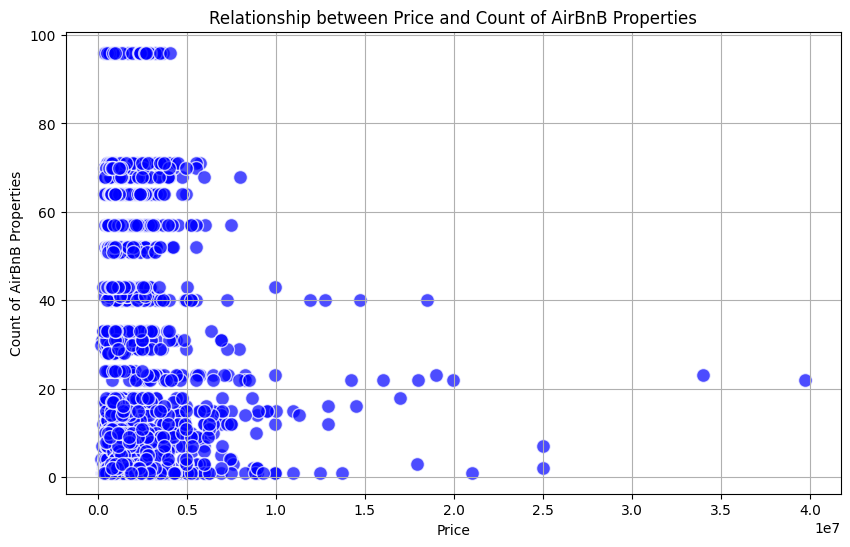

In [308]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(result_df['Price'], result_df['Count of Airbnb'], alpha=0.7, c='blue', edgecolors='w', s=100)

plt.title('Relationship between Price and Count of AirBnB Properties')
plt.xlabel('Price')
plt.ylabel('Count of AirBnB Properties')

plt.grid(True)
plt.show()

It can be observed in the above plot that the higher the Airbnb properties count, the lesser the price of houses, whereas the lower the Airbnb properties count, the higher the price of houses.

## Average House Price by Count of AirBnBs

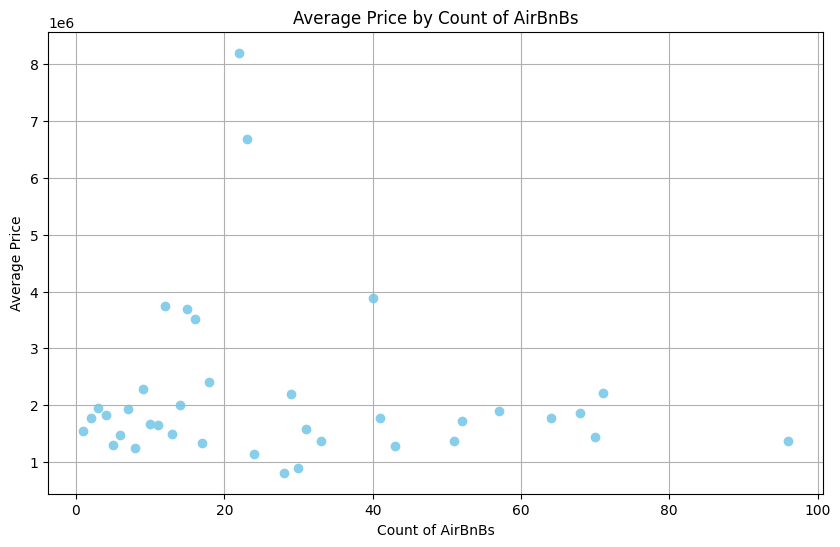

In [319]:
# Group by 'Count of AirBnBs' and calculate average price
grouped_df = result_df.groupby('Count of Airbnb').agg({'Price': 'mean'}).reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(grouped_df['Count of Airbnb'], grouped_df['Price'], color='skyblue')
plt.xlabel('Count of AirBnBs')
plt.ylabel('Average Price')
plt.title('Average Price by Count of AirBnBs')
plt.grid(True)
plt.show()

The relationship between house prices and number of Airbnb shows that the higher the Airbnb count, the lower the house price is. Whereas, when the Airbnb count is less, the house prices are more.

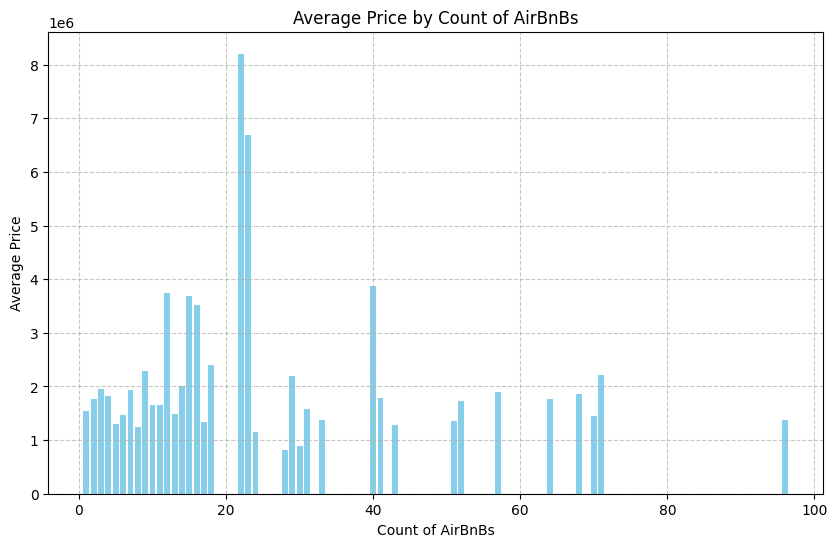

In [321]:
# Group by 'Count of AirBnBs' and calculate average price
grouped_df = result_df.groupby('Count of Airbnb').agg({'Price': 'mean'}).reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(grouped_df['Count of Airbnb'], grouped_df['Price'], color='skyblue')
plt.xlabel('Count of AirBnBs')
plt.ylabel('Average Price')
plt.title('Average Price by Count of AirBnBs')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Machine Learning

Count of Airbnb is based upon the Location

In [68]:
result_df = pd.read_csv('result_df.csv',index_col=False)
result_df.drop(columns=result_df.columns[0],inplace=True)

In [144]:
cols_needed = ['Property Name','House Type','Area in sq ft','No. of Bedrooms','No. of Bathrooms','No. of Receptions','Location','Point','Count of Airbnb','Price']
df_new = result_df[cols_needed]

In [145]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'House Type' column
df_new['House_Type_encoded'] = label_encoder.fit_transform(df_new['House Type'])

/tmp/ipykernel_2027/1253130994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['House_Type_encoded'] = label_encoder.fit_transform(df_new['House Type'])


## Correlation between every feature

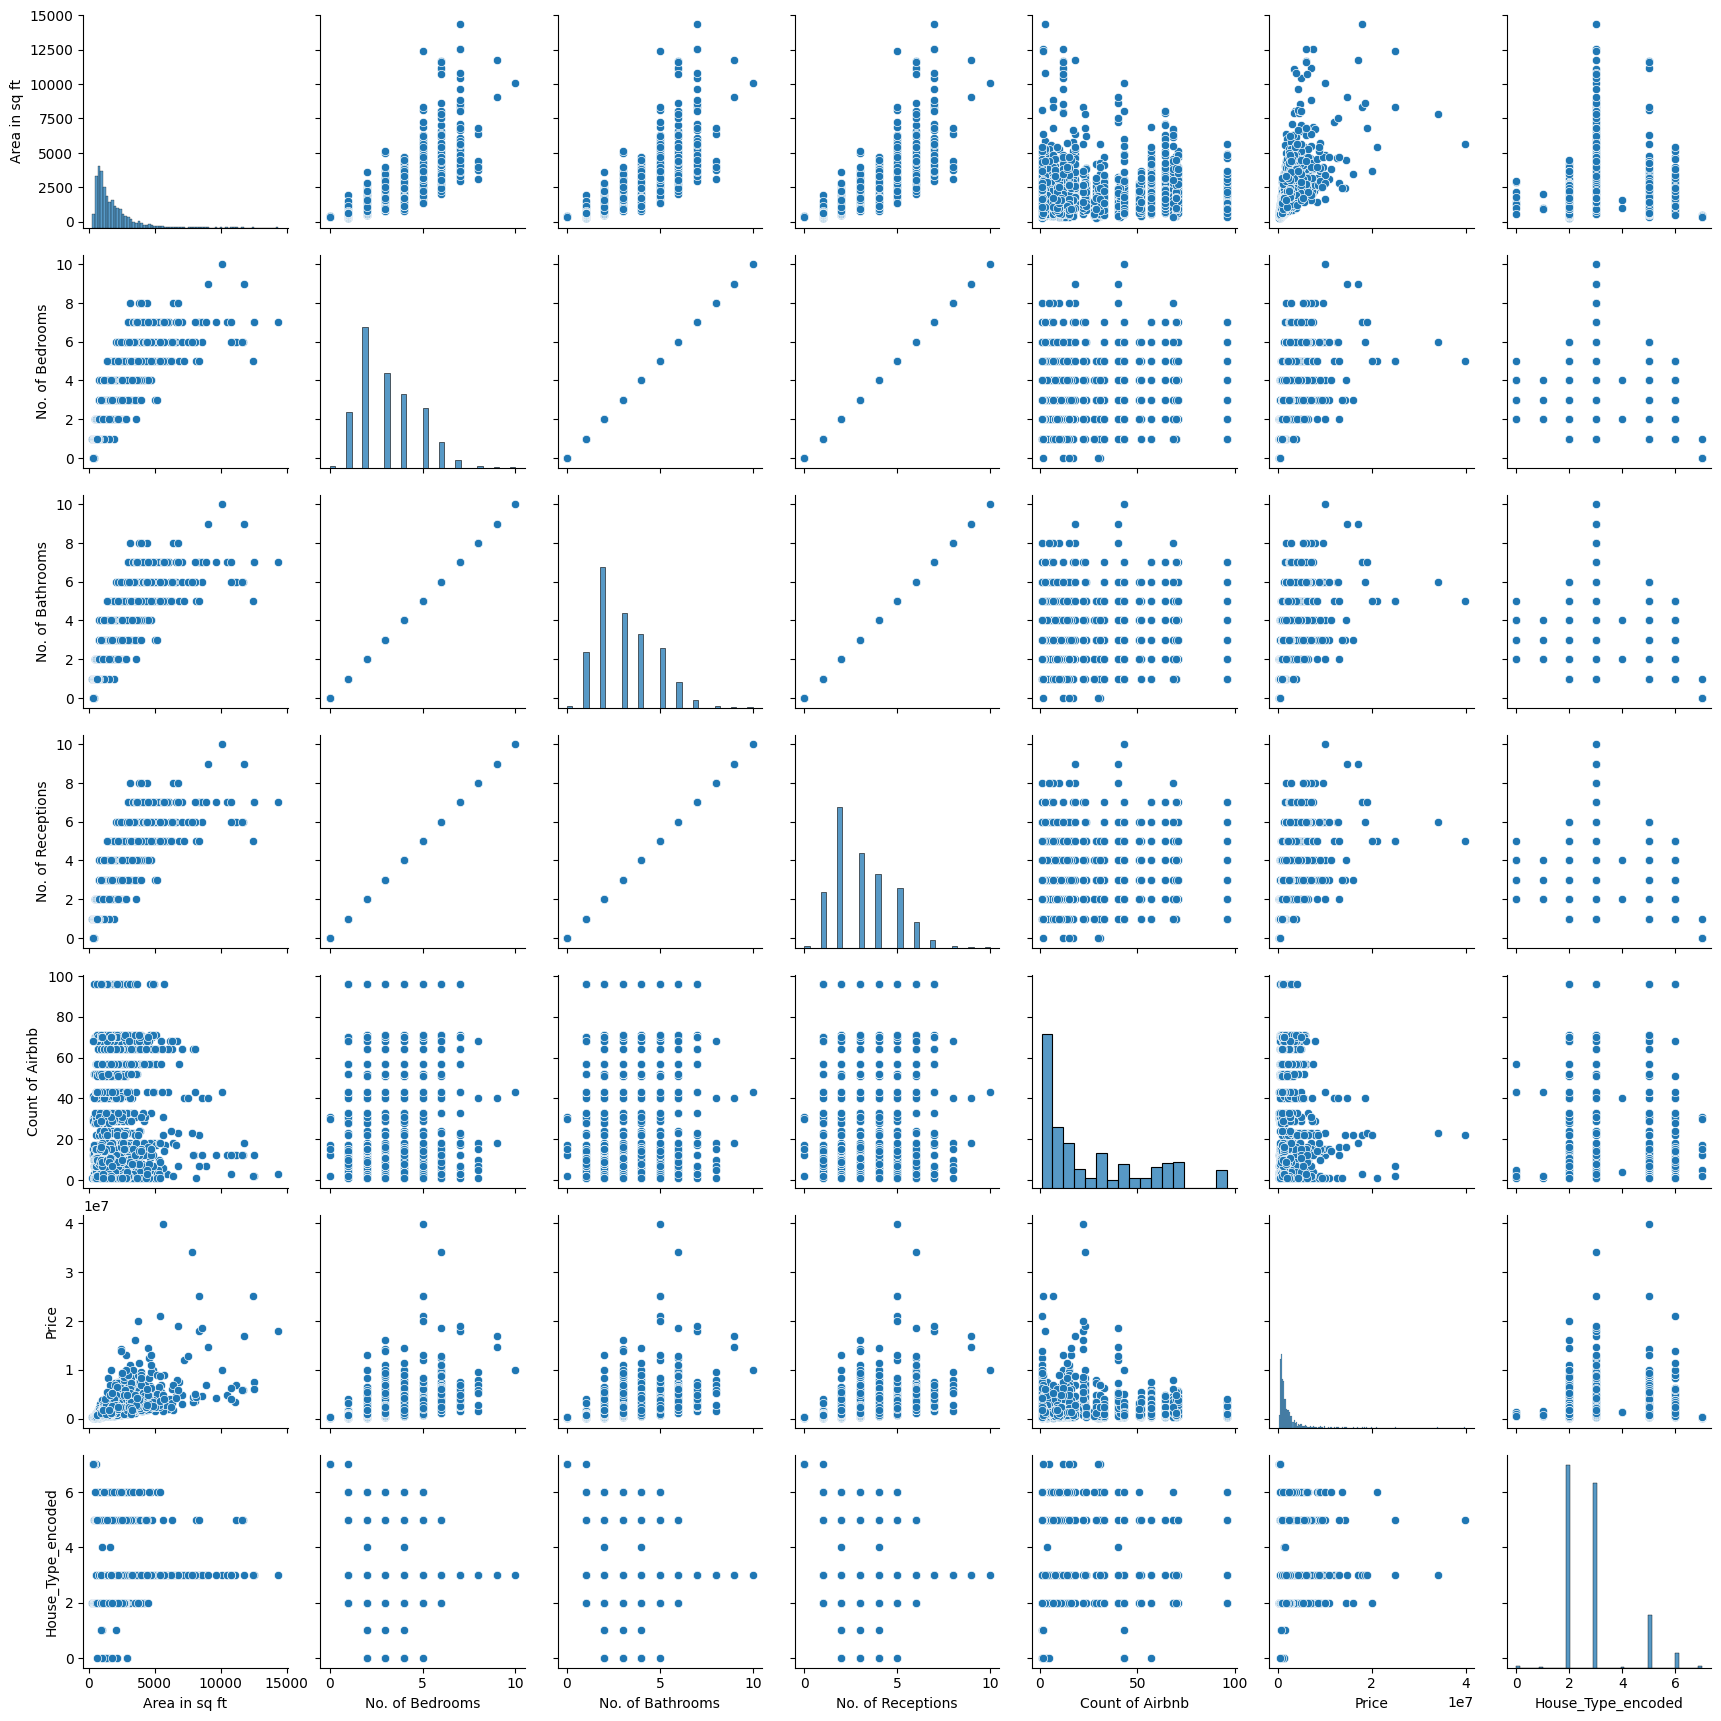

In [149]:
sns.pairplot(df_new)

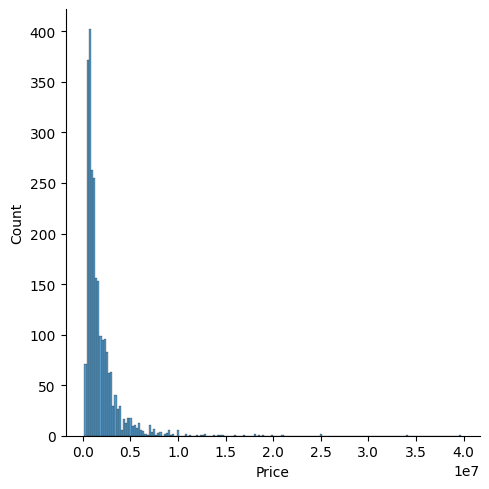

In [151]:
sns.displot(df_new['Price'])

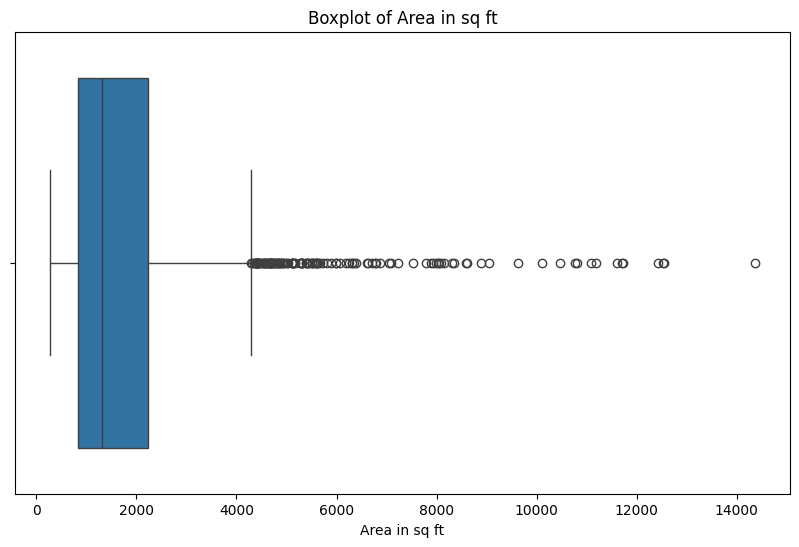

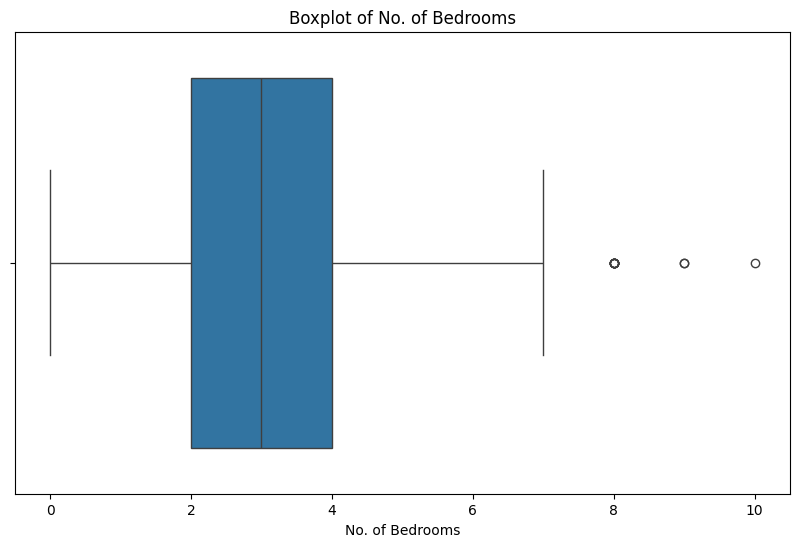

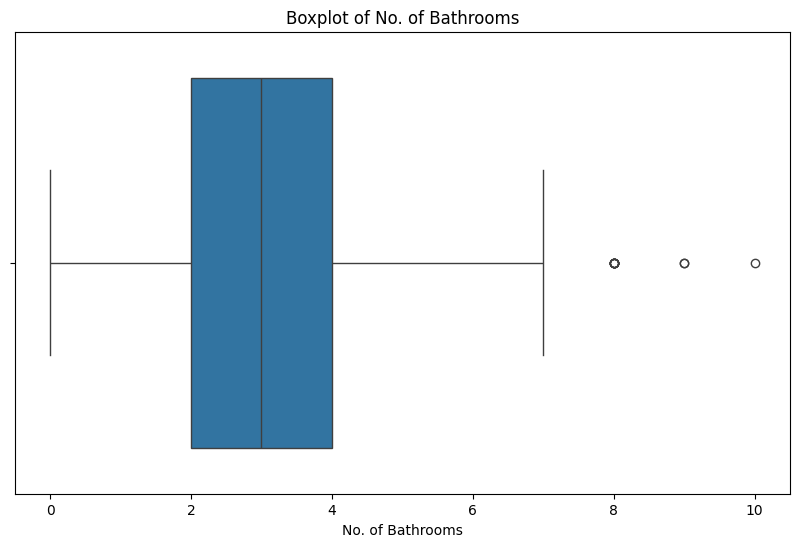

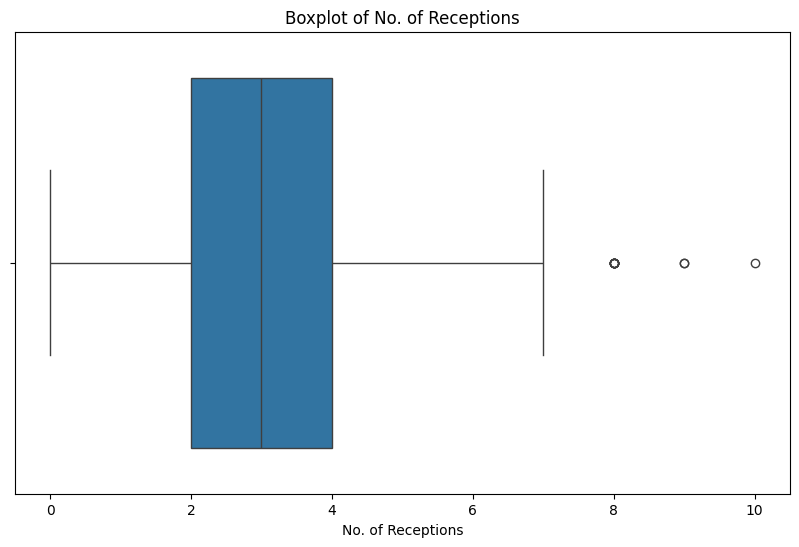

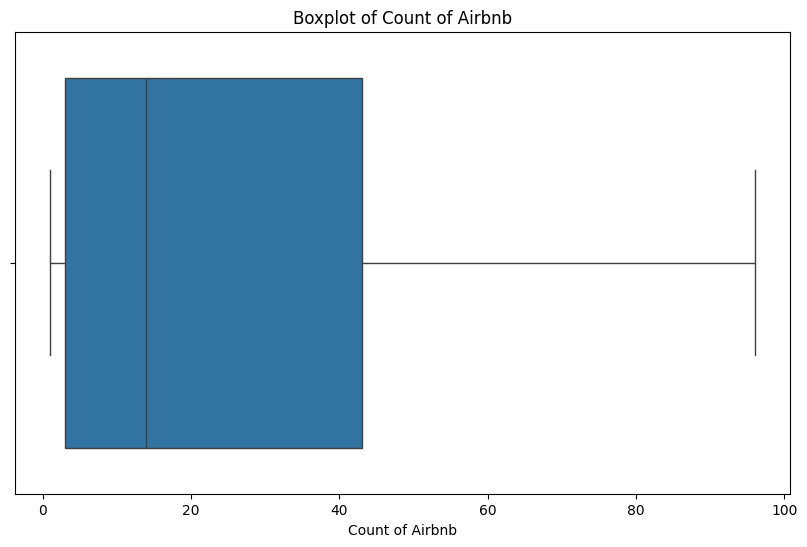

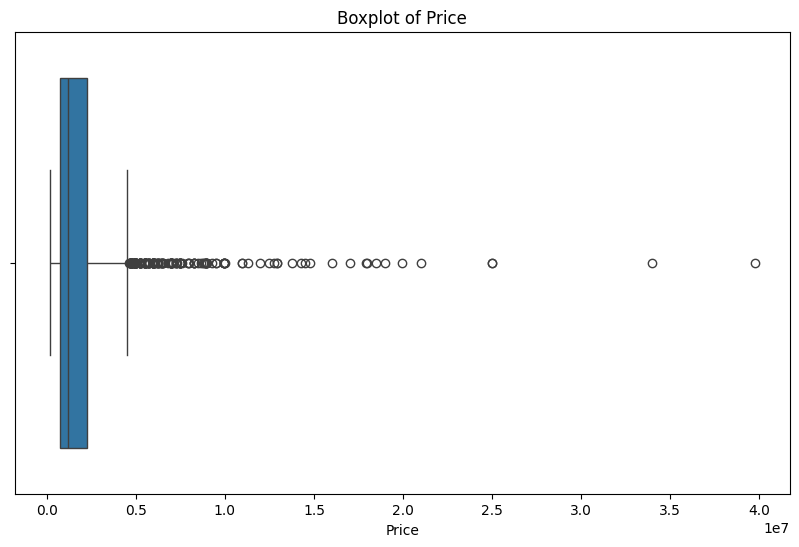

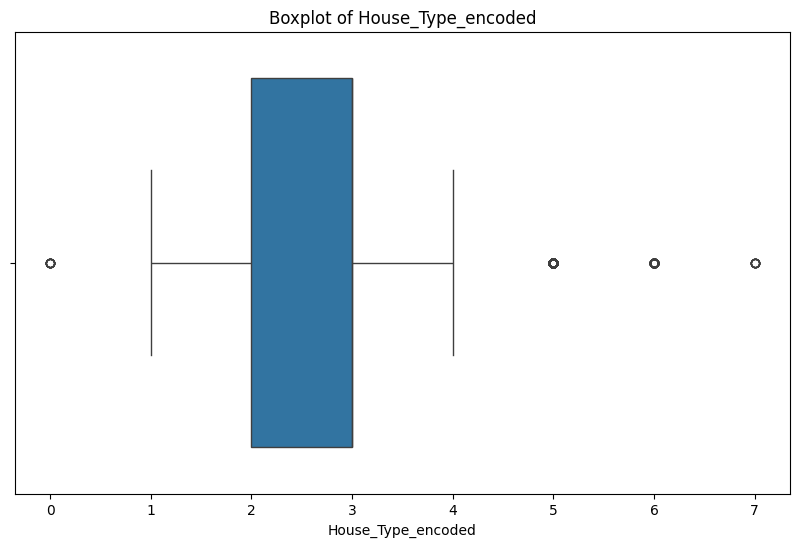

In [199]:
# Plot boxplot
for col in df_new.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_new[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

## Removing outliers from the data

In [166]:
# Define function to remove outliers based on IQR
def remove_outliers_iqr(df):
    cleaned_df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        cleaned_df = cleaned_df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]
    return cleaned_df

# Remove outliers
cleaned_df = remove_outliers_iqr(df_new)

/tmp/ipykernel_2027/4244085925.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = cleaned_df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]
/tmp/ipykernel_2027/4244085925.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = cleaned_df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]
/tmp/ipykernel_2027/4244085925.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = cleaned_df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]
/tmp/ipykernel_2027/4244085925.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = cleaned_df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]
/tmp/ipykernel_2027/4244085925.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = cleaned_df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5

In [167]:
cleaned_df

,Property Name,House Type,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,Point,Count of Airbnb,Price,House_Type_encoded
0,Queens Road,House,2716,5,5,5,Wimbledon,"(525975, 171085)",68,1675000,3
1,Seward Street,Flat / Apartment,814,2,2,2,Clerkenwell,"(532052, 182547)",28,650000,2
2,Hotham Road,Flat / Apartment,761,2,2,2,Putney,"(523492, 175507)",96,735000,2
3,Festing Road,House,1986,4,4,4,Putney,"(523557, 175957)",96,1765000,3
4,Spencer Walk,Flat / Apartment,700,2,2,2,Putney,"(523591, 175326)",96,675000,2
...,...,...,...,...,...,...,...,...,...,...,...
2482,Lauderdale Drive,House,3176,5,5,5,Richmond,"(517805, 172399)",57,2150000,3
2485,Ironmonger Lane,House,3660,4,4,4,The City,"(532537, 181248)",1,4300000,3
2487,Manor Road,House,3286,4,4,4,Loughton,"(540710, 198033)",8,1750000,3
2488,Claydon House,Flat / Apartment,1080,2,2,2,Waterfront Drive,"(526491, 176879)",1,1850000,2


## Selecting features for model training

In [168]:
# Define features and target
X = cleaned_df[['House_Type_encoded','Area in sq ft','No. of Bedrooms','No. of Bathrooms','No. of Receptions','Count of Airbnb']]
y = cleaned_df['Price']

In [169]:
X

,House_Type_encoded,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Count of Airbnb
0,3,2716,5,5,5,68
1,2,814,2,2,2,28
2,2,761,2,2,2,96
3,3,1986,4,4,4,96
4,2,700,2,2,2,96
...,...,...,...,...,...,...
2482,3,3176,5,5,5,57
2485,3,3660,4,4,4,1
2487,3,3286,4,4,4,8
2488,2,1080,2,2,2,1


In [170]:
y

0       1675000
1        650000
2        735000
3       1765000
4        675000
         ...   
2482    2150000
2485    4300000
2487    1750000
2488    1850000
2491    1750000
Name: Price, Length: 1926, dtype: int64

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

## Linear Regression Model

In [172]:
lm = LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)

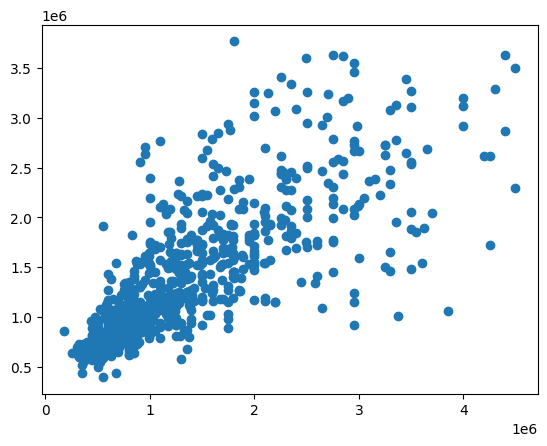

In [173]:
plt.scatter(y_test,predictions)

In [174]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 384433.81715576624
MSE: 304503095741.7656
RMSE: 551817.9914987963


## Data Normalization
With Scaling

In [187]:
scaler = MinMaxScaler()

In [188]:
# Separate the features
features_to_normalize = ['Area in sq ft', 'Count of Airbnb']
features_to_normalize_df = X[features_to_normalize]
features_unchanged_df = X.drop(columns=features_to_normalize)


# Normalize the selected features
normalized_features = scaler.fit_transform(features_to_normalize_df)

# Create a DataFrame for the normalized features
normalized_features_df = pd.DataFrame(normalized_features, index=X.index, columns=features_to_normalize)

# Combine the normalized features with the unchanged features
normalized_df = pd.concat([normalized_features_df, features_unchanged_df], axis=1)

In [190]:
normalized_df

,Area in sq ft,Count of Airbnb,House_Type_encoded,No. of Bedrooms,No. of Bathrooms,No. of Receptions
0,0.618071,0.705263,3,5,5,5
1,0.136674,0.284211,2,2,2,2
2,0.123260,1.000000,2,2,2,2
3,0.433308,1.000000,3,4,4,4
4,0.107821,1.000000,2,2,2,2
...,...,...,...,...,...,...
2482,0.734498,0.589474,3,5,5,5
2485,0.856998,0.000000,3,4,4,4
2487,0.762339,0.073684,3,4,4,4
2488,0.203999,0.000000,2,2,2,2


### Splitting data into training and testing set

In [191]:
X_train, X_test, y_train, y_test = train_test_split(normalized_df, y, test_size = 0.2, random_state = 42)

In [192]:
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", y_test.shape)

X_train shape:  (1540, 6)
Y_train shape:  (1540,)
X_test shape:  (386, 6)
Y_test shape:  (386,)


#### Initialize the model

In [193]:
regr = LinearRegression()

#### Train the model

In [194]:
regr.fit(X_train, y_train) 

LinearRegression()

In [195]:
print(f"Score : {regr.score(X_test, y_test)}") 

Score : 0.5573799900906371


#### Prediction

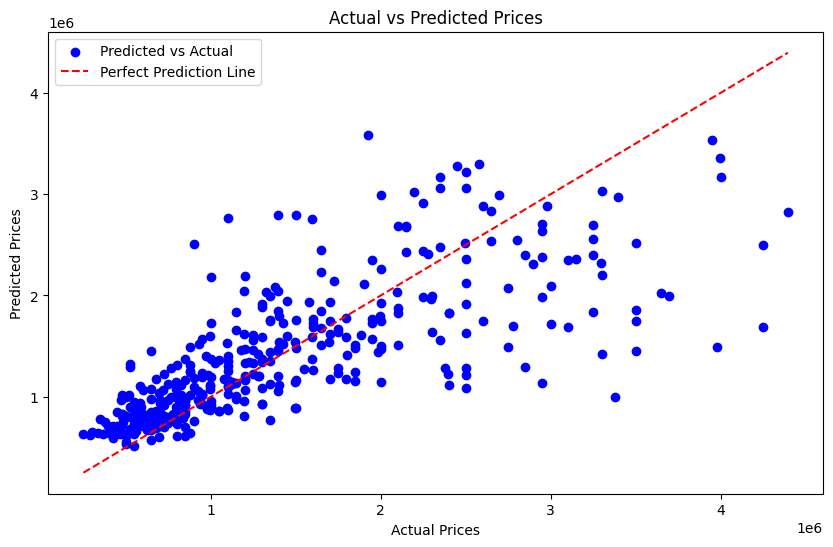

In [196]:
# Make predictions
y_pred = regr.predict(X_test)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='b', label='Predicted vs Actual')

# Plot the line of perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', linestyle='--', label='Perfect Prediction Line')

plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

### Interpreting Coefficients

In [197]:
# Assuming X_train is your DataFrame with feature names
feature_names = X_train.columns

# Create a DataFrame to display the coefficients
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': regr.coef_
})

# Sort by absolute value of coefficients for better readability
coeff_df['Absolute Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Absolute Coefficient', ascending=False).drop('Absolute Coefficient', axis=1)

In [200]:
coeff_df

,Feature,Coefficient
0,Area in sq ft,3.630986e+06
2,House_Type_encoded,-2.083423e+05
1,Count of Airbnb,-1.162393e+05
5,No. of Receptions,-1.347570e+04
4,No. of Bathrooms,-1.347570e+04
3,No. of Bedrooms,-1.347570e+04


### Interpretation of Coefficients

**Area in sq ft:** `3.630986e+06`  
This large positive coefficient suggests that the area in square feet has a substantial positive effect on the target variable (e.g., price). A one-unit increase in the area is associated with an increase of approximately 3,630,986 in the target value. This indicates that larger properties tend to have significantly higher prices.

**House_Type_encoded:** `-2.083423e+05`  
This negative coefficient indicates that the encoded house type has a negative impact on the target variable. The specific impact depends on how house types are encoded. For example, if house types are represented numerically, this coefficient suggests that certain house types could decrease the target value, potentially indicating that these types are less valuable.

**Count of Airbnb:** `-1.162393e+05`  
This negative coefficient means that an increase in the count of Airbnb properties is associated with a decrease in the target variable. This might suggest that higher competition (more Airbnb properties) could lead to lower prices or a less valuable target.

**No. of Receptions:** `-1.347570e+04`  
This negative coefficient implies that having more receptions is associated with a decrease in the target variable. This might seem counterintuitive unless there is a specific reason (e.g., more receptions could be correlated with less desirable aspects or other features that negatively affect the target).

**No. of Bathrooms:** `-1.347570e+04`  
Similar to the number of receptions, this negative coefficient suggests that having more bathrooms is associated with a decrease in the target variable. This might be unexpected as more bathrooms are typically considered a positive feature, indicating that other factors may be influencing the target variable.

**No. of Bedrooms:** `-1.347570e+04`  
This negative coefficient indicates that having more bedrooms is associated with a decrease in the target variable. This is counterintuitive since more bedrooms are generally associated with higher property values. The result might suggest that other variables or conditions are affecting the target value in a way that overshadows the typical positive impact of additional bedrooms.

### Visualization of coefficients

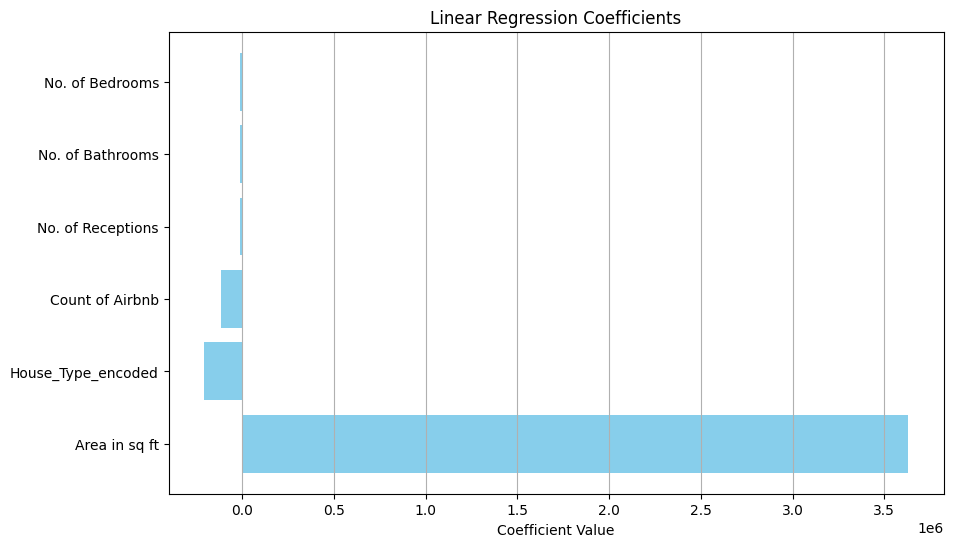

In [201]:
# Plotting the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coeff_df['Feature'], coeff_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Linear Regression Coefficients')
plt.grid(axis='x')
plt.show()

### Relationship between House Price and Other features as follows:
1. 'House_Type_encoded'
2. 'Area in sq ft'
3. 'No. of Bedrooms'
4. 'No. of Bathrooms'
5. 'No. of Receptions'
6. 'Count of Airbnb'

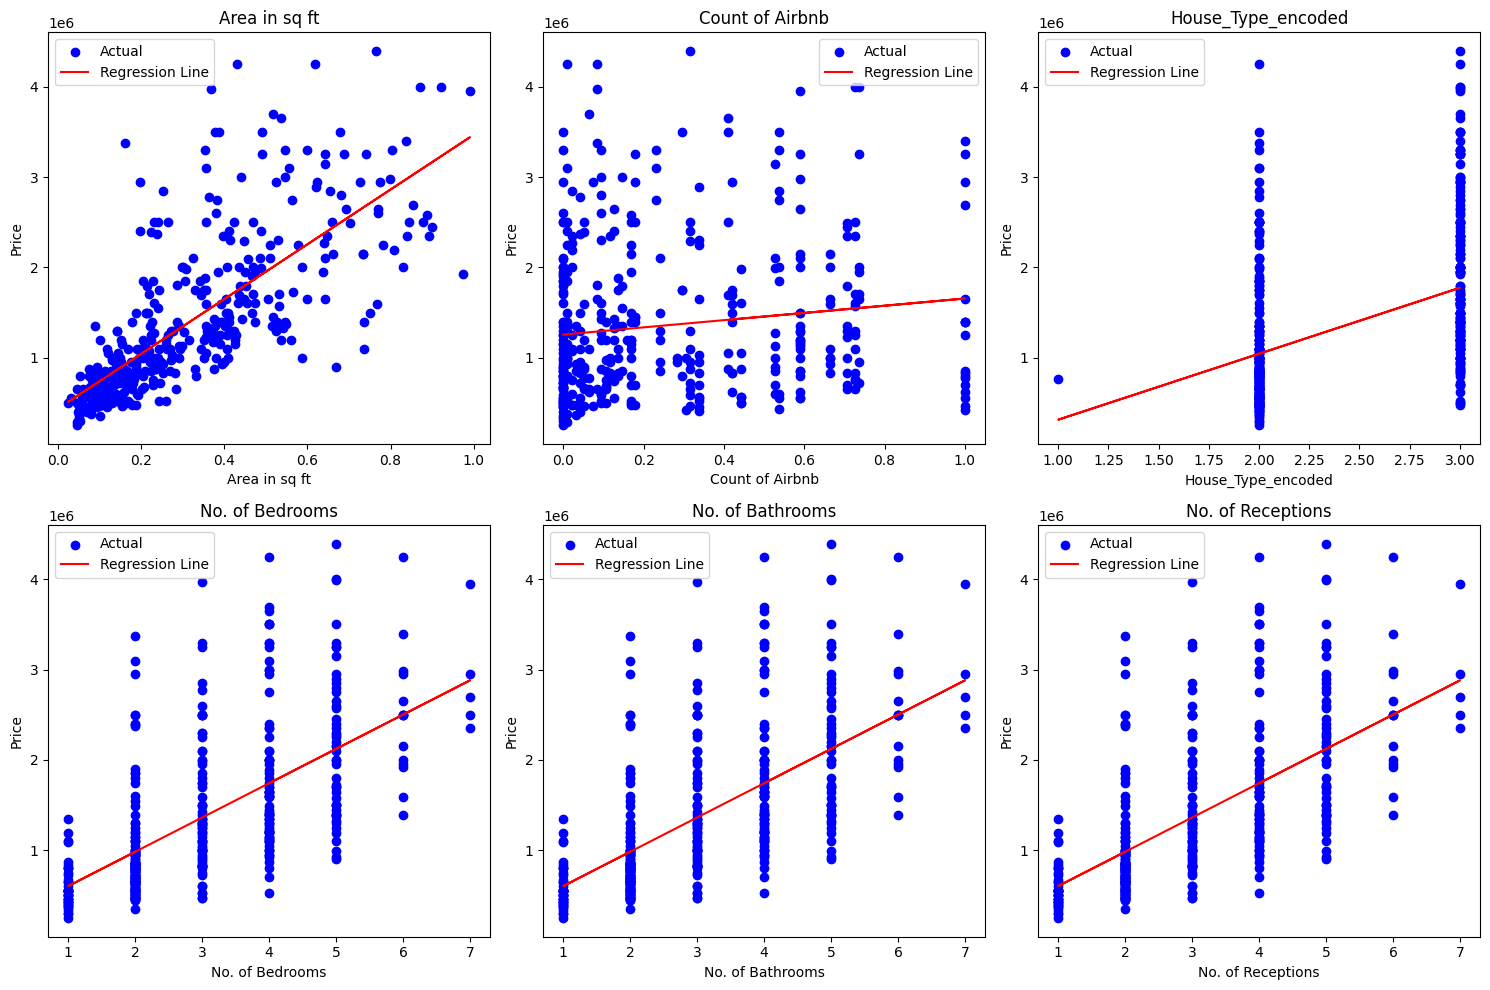

In [202]:
# Number of features
num_features = X_train.shape[1]
# regr = LinearRegression()
# Plotting
plt.figure(figsize=(15, 10))
for i in range(num_features):
    regr = LinearRegression()
    feature_name = X_test.columns[i]  # Get feature name
    plt.subplot(2, 3, i + 1)
    
    # Extract feature data
    X_test_feature = X_test[[feature_name]]
    X_train_feature = X_train[[feature_name]]
    
    # Fit the model on the single feature
    regr.fit(X_train_feature, y_train)
    y_pred = regr.predict(X_test_feature)
    
    # Plotting
    plt.scatter(X_test_feature, y_test, color='b', label='Actual')
    plt.plot(X_test_feature, y_pred, color='r', label='Regression Line')
    plt.xlabel(feature_name)
    plt.ylabel('Price')
    plt.title(f'{feature_name}')
    plt.legend()

plt.tight_layout()
plt.show()

# Conclusions:
<div style="text-align: justify"> The findings of the current study emphasize the need for policymakers to take into account local tourist and hosing market variables when developing Airbnb regulation. It also adds to the continuing debate about the significance of submarket analysis for Airbnb and housing activities. 
The rapid spread of borderless and un-regulated home-sharing Airbnb has raised concerns about their impact on local communities and housing. Policymakers and local governments should begin implementing variety of regulatory measures in response to the concerns such as influence of Airbnb on housing prices.  

The study findings can likely contribute to a more informed and evidence-based debate about the right degree and type of regulation for home-sharing platforms by examining their impact on housing markets. </div>

# References:

* Guttentag, D., Smith, S., Potwarka, L., & Havitz, M. (2018). Why tourists choose Airbnb: A motivation-based segmentation study. Journal of Travel Research, 57(3), 342-359.

* Shabrina, Z., Arcaute, E., & Batty, M. (2022). Airbnb and its potential impact on the London housing market. Urban Studies, 59(1), 197-221.

* Zervas, G., Proserpio, D., & Byers, J. W. (2017). The rise of the sharing economy: Estimating the impact of Airbnb on the hotel industry. Journal of marketing research, 54(5), 687-705.
